# 缺失值处理
## 1.缺失值含义分析与删除

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
local_path = "/home/jwzhang411898961/Dropbox/DataScience/Kaggle/HousingPrice"

df_train = pd.read_csv(local_path + "/train.csv")
df_test = pd.read_csv(local_path + "/test.csv")

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
na_count = df_train.isnull().sum().sort_values(ascending=False)
na_rate = na_count / df_train.shape[0]
na_data = pd.concat([na_count, na_rate], axis=1, keys=['count', 'ratio'])
na_data.head(20)

,count,ratio
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [6]:
df_train.drop(na_data[na_data['count']>1].index, axis=1, inplace=True)
df_train.dropna(subset=['Electrical'], axis=0, how='all', inplace=True)

In [7]:
df_train.shape

(1459, 63)

## 2.缺失值补全与变换

In [8]:
df_tr = pd.read_csv(local_path + "/train.csv").drop(['Id'], axis=1)
df_X = df_tr.drop(['SalePrice'], axis=1)
df_y = df_tr['SalePrice']

quantity = [attr for attr in df_X.columns if df_X.dtypes[attr] != 'object']
quality = [attr for attr in df_X.columns if df_X.dtypes[attr] == 'object']

# 类型变量缺失值补全
for c in quality:
    df_tr[c] = df_tr[c].astype('category')
    if df_tr[c].isnull().any():
        df_tr[c] = df_tr[c].cat.add_categories(['MISSING']) 
        # fillna requires a value already existing as category. "MISSING" is a categorical dtype.
        df_tr[c] = df_tr[c].fillna('MISSING')
 
# 连续变量缺失值补全 
quantity_missing_cal = df_tr[quantity].isnull().sum().sort_values(ascending=False) # is a Series
missing_cols = quantity_missing_cal[quantity_missing_cal>0].index
df_tr[missing_cols] = df_tr[missing_cols].fillna(0.)
df_tr[missing_cols].isnull().sum()

LotFrontage    0
GarageYrBlt    0
MasVnrArea     0
dtype: int64

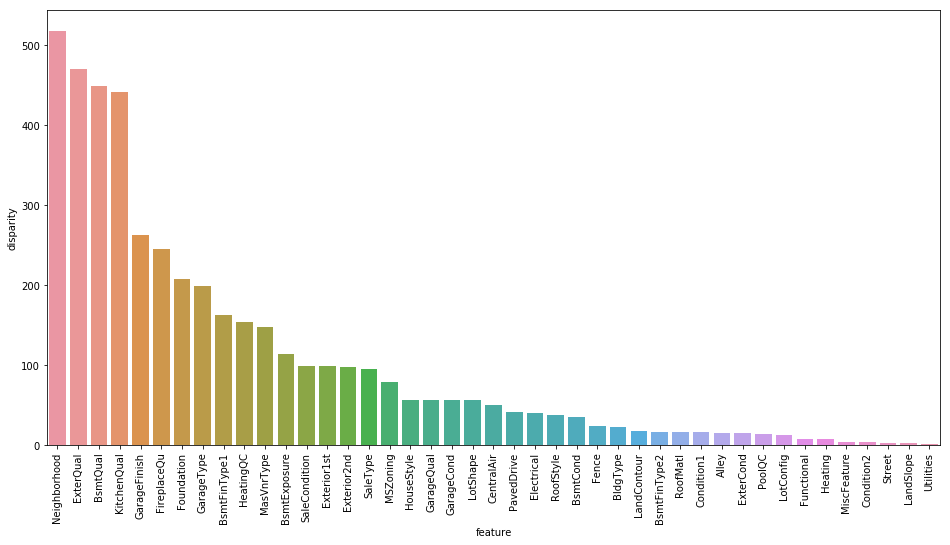

In [9]:
def anova(frame, qualitative):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s) # 某特征下不同取值对应的房价组合形成二维列表
#             print("Samples is {0}".format(samples))
        pval = stats.f_oneway(*samples)[1] # 一元方差分析得到 F，P，要的是 P，P越小，对方差的影响越大。
#         print("p value is {0}".format(pval))
        pvals.append(pval)
    anv['pval'] = pvals
#     print(anv)
    return anv.sort_values('pval')

a = anova(df_tr,quality)
# print("_" * 40)
# print(a)
a['disparity'] = np.log(1./a['pval'].values)  # 悬殊度
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)
plt.show()

**由上图示分析可见，不少离散变量的具体取值对最终房价会产生较大影响（例如Neighborhood这个变量，实际上暗含了地段这个影响房价的重要因素），因此，我们可以按照各离散变量相应取值下房价的均值来给各个取值划定一个1,2,3,4来定量描述他们对房价的影响，也就是将离散变量转化为数值型的有序变量：**

In [10]:
def encode(frame, feature):
    '''
    对所有类型变量，依照各个类型变量的不同取值对应的样本集内房价的均值，按照房价均值高低
    对此变量的当前取值确定其相对数值1,2,3,4等等，相当于对类型变量赋值使其成为连续变量。
    此方法采用了与One-Hot编码不同的方法来处理离散数据，值得学习
    注意：此函数会直接在原frame的DataFrame内创建新的一列来存放feature编码后的值。
    '''
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['price_mean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    # 上述 groupby()操作可以将某一feature下同一取值的数据整个到一起，结合mean()可以直接得到该特征不同取值的房价均值
    ordering = ordering.sort_values('price_mean')
    ordering['order'] = range(1, ordering.shape[0]+1)
    ordering = ordering['order'].to_dict()
    for attr_v, score in ordering.items():
        # e.g. qualitative[2]: {'Grvl': 1, 'MISSING': 3, 'Pave': 2}
        frame.loc[frame[feature] == attr_v, feature+'_E'] = score # 原数据集每个feature增加一个分数列 "feature_E"

quality_encoded = []
# 由于qualitative集合中包含了非数值型变量和伪数值型变量（多为评分、等级等，其取值为1,2,3,4等等）两类
# 因此只需要对非数值型变量进行encode()处理。
# 如果采用One-Hot编码，则整个qualitative的特征都要进行pd,get_dummies()处理
for q in quality:
    encode(df_tr, q)
    quality_encoded.append(q+'_E')
df_tr.drop(quality, axis=1, inplace=True)  # 离散变量已经有了编码后的新变量，因此删去原变量
# df_tr.shape = (1460, 80)
print(quality_encoded, '\n{} qualitative attributes have been encoded.'.format(len(quality_encoded)))
# print(df_tr['HouseStyle_E'].value_counts())
# print(df_tr['MSZoning_E'].value_counts())

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E'] 
43 qualitative attributes have been encoded.
6.0    726
7.0    445
3.0    154
5.0     65
2.0     37
1.0     14
4.0     11
8.0      8
Name: HouseStyle_E, dtype: int64
4.0    1151
2.0     218
5.0      65
3.0      16
1.0      10
Name: MSZoning_E, dtype: int64


## 特征互相关分析与特征选取

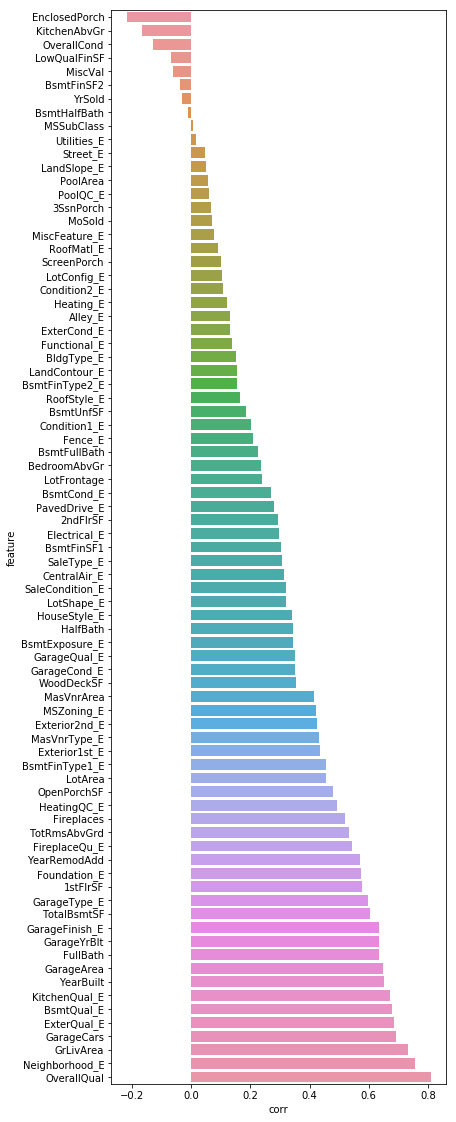

In [11]:
def spearman(frame, features):
    '''
    采用“斯皮尔曼等级相关”来计算变量与房价的相关性(可查阅百科)
    此相关系数简单来说，可以对上述encoder()处理后的等级变量及其它与房价的相关性进行更好的评价（特别是对于非线性关系）
    '''
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['corr'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('corr')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='corr', orient='h')    
features = quantity + quality_encoded
spearman(df_tr, features)

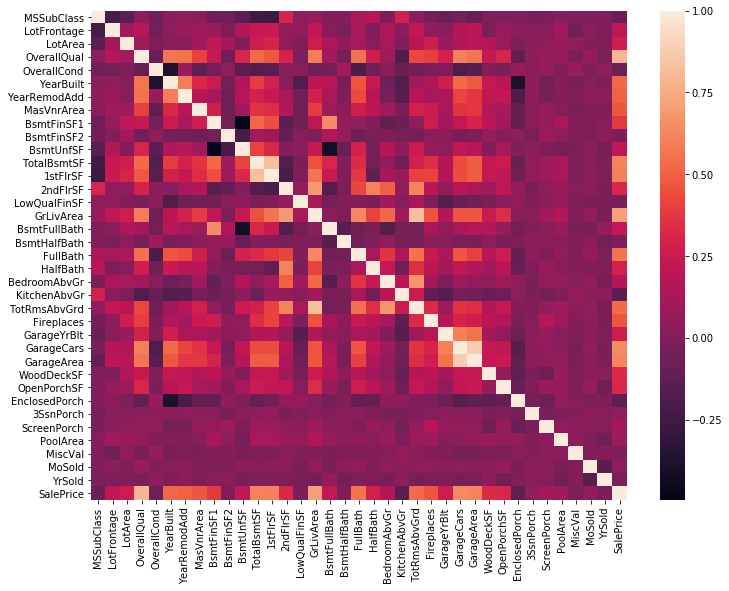

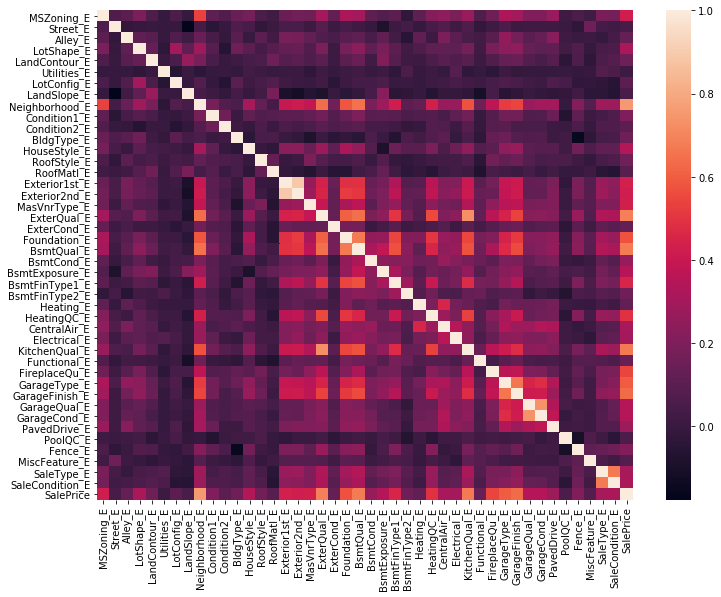

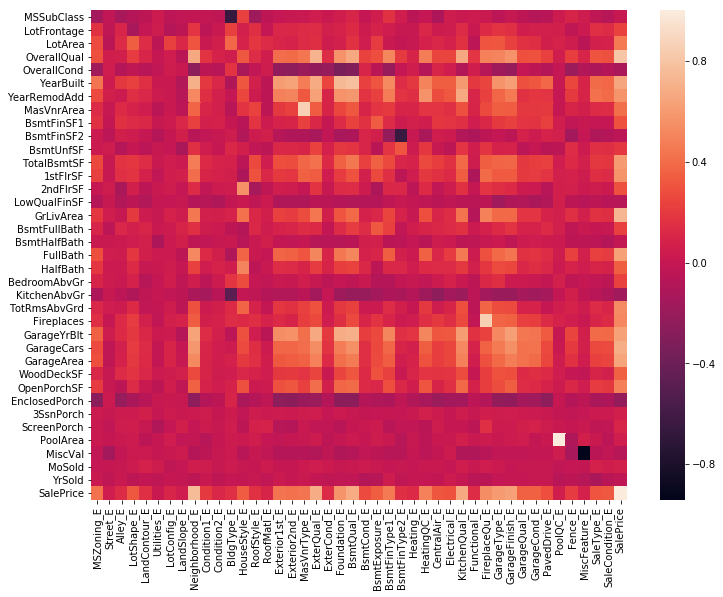

In [12]:
plt.figure(1,figsize=(12,9))  # 连续型变量相关图
corr = df_tr[quantity+['SalePrice']].corr()
sns.heatmap(corr)

plt.figure(2,figsize=(12,9))  # 等级型变量相关图（离散型和伪数值型变量均已被概括为等级型变量）
corr = df_tr[quality_encoded+['SalePrice']].corr('spearman')
sns.heatmap(corr)

plt.figure(3,figsize=(12,9)) # 连续型变量-等级型变量相关图
corr = pd.DataFrame(np.zeros([len(quantity)+1, len(quality_encoded)+1]), 
                    index=quantity+['SalePrice'], columns=quality_encoded+['SalePrice'])
for q1 in quantity+['SalePrice']:
    for q2 in quality_encoded+['SalePrice']:
        corr.loc[q1, q2] = df_tr[q1].corr(df_tr[q2], 'spearman')
sns.heatmap(corr)

MSSubClass         59.565854
LotFrontage        53.802927
LotArea          9067.083902
OverallQual         5.506341
OverallCond         5.655610
YearBuilt        1962.481951
YearRemodAdd     1978.853659
MasVnrArea         64.260488
BsmtFinSF1        364.446829
BsmtFinSF2         46.875122
BsmtUnfSF         505.382439
TotalBsmtSF       916.704390
1stFlrSF         1039.745366
2ndFlrSF          268.669268
LowQualFinSF        6.414634
GrLivArea        1314.829268
BsmtFullBath        0.362927
BsmtHalfBath        0.067317
FullBath            1.389268
HalfBath            0.318049
BedroomAbvGr        2.789268
KitchenAbvGr        1.062439
TotRmsAbvGrd        6.053659
Fireplaces          0.461463
GarageYrBlt      1819.551220
GarageCars          1.518049
GarageArea        401.615610
WoodDeckSF         73.447805
OpenPorchSF        33.525854
EnclosedPorch      25.609756
3SsnPorch           2.700488
ScreenPorch        12.701463
PoolArea            1.662439
MiscVal            52.189268
MoSold        

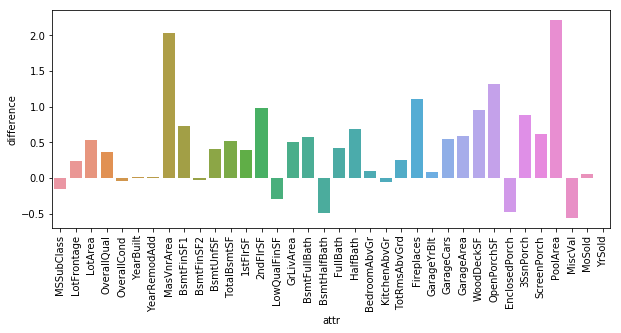

In [16]:
# 给房价分段，并由此查看各段房价内那些特征的取值会出现悬殊
poor = df_tr[df_tr['SalePrice'] < 200000][quantity].mean()
print(poor)
pricey = df_tr[df_tr['SalePrice'] >= 200000][quantity].mean()
print(pricey)
diff = pd.DataFrame()
diff['attr'] = quantity
diff['difference'] = ((pricey-poor)/poor).values
plt.figure(figsize=(10,4))
sns.barplot(data=diff, x='attr', y='difference')
plt.xticks(rotation=90)
plt.show()

## 数据变换与归一化
经过上述分析与处理后，我们还需要对数据进行处理，使其能够按照学习器的特性进行学习，这其中最重要的便是调整数据的分布为正态分布

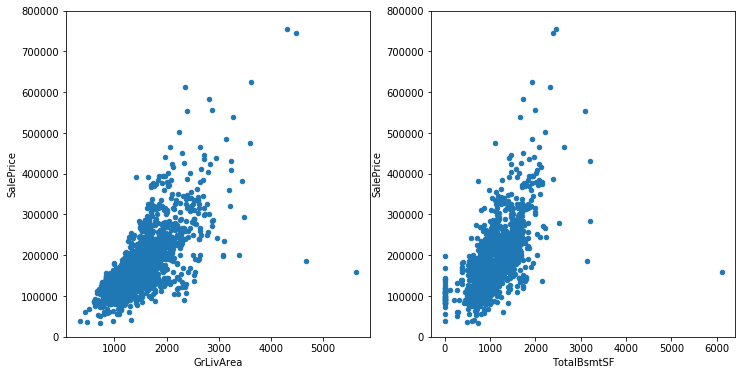

In [17]:
output,var,var1 = 'SalePrice', 'GrLivArea', 'TotalBsmtSF'
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
df_train.plot.scatter(x=var,y=output,ylim=(0,800000),ax=axes[0])
df_train.plot.scatter(x=var1,y=output,ylim=(0,800000),ax=axes[1])

由此可见，数据存在两个问题：1、存在离群点（居住面积、地下室特别大然而房价低），这样的点显然应该去掉；2、数据整体在左下角密集而右上角稀疏，呈圆锥状，这样的数据具有同方差性(homoscedasticity)，需要进行处理。

In [18]:
df_train.sort_values(by='GrLivArea', ascending=False)[:2]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


In [19]:
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

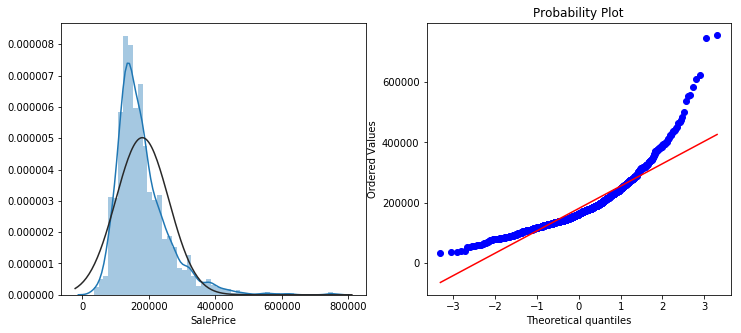

In [22]:
from scipy.stats import norm

fig = plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.distplot(df_train[output], fit=norm)
plt.subplot(122)
res = stats.probplot(df_train[output], plot=plt)
plt.show()

观察直方图和概率图可以发现，数据具有明显的正偏性，因此可采用对数来缓解这种趋势

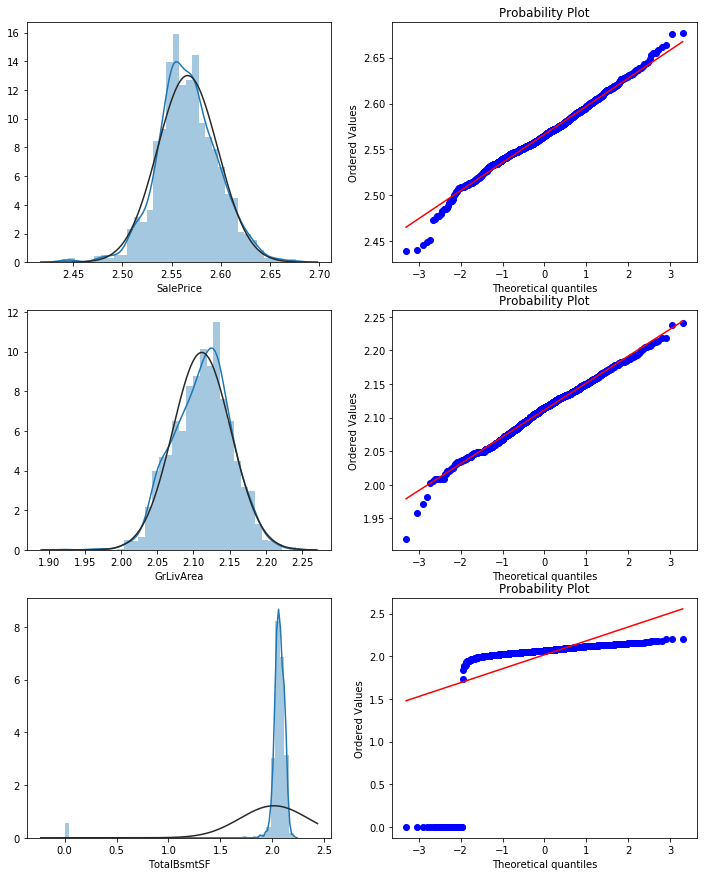

In [26]:
def log_transform(feature):
    # np.log1p(x) = log(1+x)，这样就可以对0值求对数（针对 `TotalBsmtSF` 这样含有0的特征）
    df_train[feature] = np.log1p(df_train[feature].values)
    
log_transform(output)
log_transform(var)
log_transform(var1)

fig = plt.figure(figsize=(12, 15))
plt.subplot(321)
sns.distplot(df_train[output], fit=norm)
plt.subplot(322)
res = stats.probplot(df_train[output], plot=plt)
plt.subplot(323)
sns.distplot(df_train[var],fit=norm)
plt.subplot(324)
res = stats.probplot(df_train[var], plot=plt)
plt.subplot(325)
sns.distplot(df_train[var1],fit=norm)
plt.subplot(326)
res = stats.probplot(df_train[var1], plot=plt)
plt.show()

从上图可见，部分特征还是存在问题，因此可以考虑构建新的特征来解决上述问题，并为这些连续变量提供新的连续或离散特征

In [24]:
df_tr['HasBasement'] = df_tr['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_tr['HasGarage'] = df_tr['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_tr['Has2ndFloor'] = df_tr['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_tr['HasMasVnr'] = df_tr['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
df_tr['HasWoodDeck'] = df_tr['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
df_tr['HasPorch'] = df_tr['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
df_tr['HasPool'] = df_tr['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_tr['IsNew'] = df_tr['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)
boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 
           'HasWoodDeck', 'HasPorch', 'HasPool', 'IsNew']

def quadratic(feature):
    df_tr[feature] = df_tr[feature[:-1]]**2

qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']
for feature in qdr:
    quadratic(feature)

除了上述连续变量的处理，对于此时的数据集中的类型变量（缺失值处理采用方法1的情况）应该进行“哑变量”处理，此步采用pd.get_dummies()与使用sklearn下的OneHotEncoder()作用是相同的。

In [25]:
df_train = pd.get_dummies(df_train)
df_train.shape   # 未考虑上述增加特征时的运行结果

(1457, 221)